In [1]:
import sys,os
sys.path.append("/nlp/scr/zyanzhe/Pix2Code")

from Pix2Code.metrics.visual_score import *
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_images_side_by_side(image_file_lst, border_color='black', border_width=0.05):
    n_images = len(image_file_lst)
    # Read the images
    images = [cv2.imread(image_file) for image_file in image_file_lst]

    # Set up the figure and subplots
    plt.figure(figsize=(40, 10))  # Adjusted the size to accommodate four images

    # Adjust subplot parameters to create space (border) between images
    plt.subplots_adjust(wspace=border_width)

    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

    # Set the background color of the figure (acts as border color)
    plt.gcf().set_facecolor(border_color)

    # Display the images
    plt.show()

In [3]:
reference_dir = "../../testset_100"
websight_predictions_dir = "../../predictions_100/websight"
direct_prompting_predictions_dir = "../../predictions_100/gpt4v_direct_prompting"
text_augmented_prompting_predictions_dir = "../../predictions_100/gpt4v_text_augmented_prompting"
revision_prompting_predictions_dir = "../../predictions_100/gpt4v_visual_revision_prompting"
finetuned_predictions_dir = "../../predictions_100/finetuned_v0"

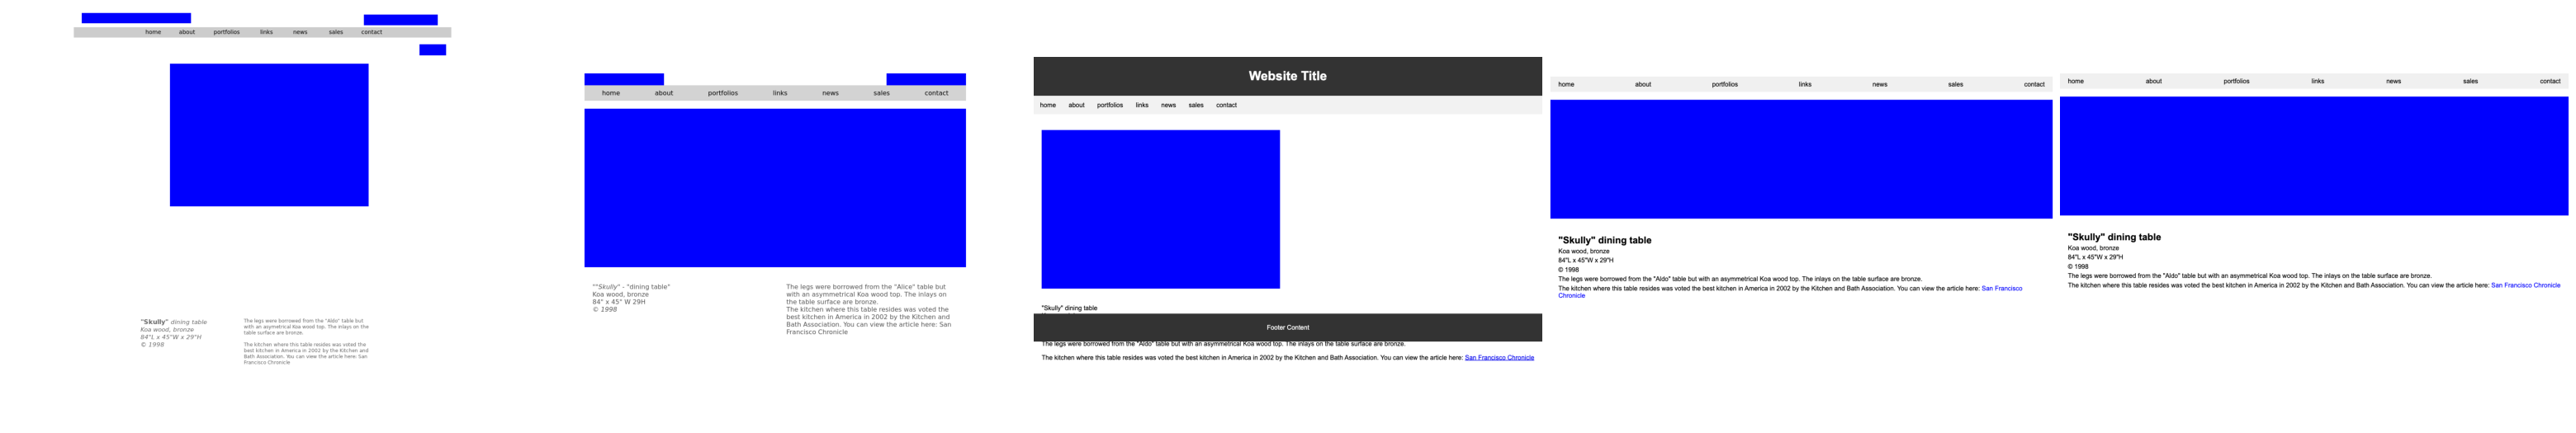

In [4]:
show_images_side_by_side((os.path.join(reference_dir, "2.png"), os.path.join(websight_predictions_dir, "2.png"), os.path.join(direct_prompting_predictions_dir, "2.png"), os.path.join(text_augmented_prompting_predictions_dir, "2.png"), os.path.join(revision_prompting_predictions_dir, "2.png")), border_color='white', border_width=0.01)

In [11]:
from copy import deepcopy
from PIL import Image, ImageDraw
from collections import Counter

def calculate_current_cost(cost_matrix, row_ind, col_ind):
    return cost_matrix[row_ind, col_ind].sum()


def merge_blocks_wo_check(block1, block2):
    # Concatenate text
    merged_text = block1['text'] + " " + block2['text']

    # Calculate bounding box
    x_min = min(block1['bbox'][0], block2['bbox'][0])
    y_min = min(block1['bbox'][1], block2['bbox'][1])
    x_max = max(block1['bbox'][0] + block1['bbox'][2], block2['bbox'][0] + block2['bbox'][2])
    y_max = max(block1['bbox'][1] + block1['bbox'][3], block2['bbox'][1] + block2['bbox'][3])
    merged_bbox = (x_min, y_min, x_max - x_min, y_max - y_min)

    # Average color
    merged_color = tuple(
        (color1 + color2) // 2 for color1, color2 in zip(block1['color'], block2['color'])
    )

    return {'text': merged_text, 'bbox': merged_bbox, 'color': merged_color}

def calculate_current_cost(cost_matrix, row_ind, col_ind):
    return cost_matrix[row_ind, col_ind].tolist()

def find_maximum_matching_debug(A, B, consecutive_bonus, window_size):
    cost_matrix = create_cost_matrix(A, B)
    cost_matrix = adjust_cost_for_context(cost_matrix, consecutive_bonus, window_size)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    current_cost = calculate_current_cost(cost_matrix, row_ind, col_ind)
    return list(zip(row_ind, col_ind)), current_cost, cost_matrix


def remove_indices(lst, indices):
    for index in sorted(indices, reverse=True):
        if index < len(lst):
            lst.pop(index)
    return lst


def merge_blocks_by_list(blocks, merge_list):
    pop_list = []
    while True:
        if len(merge_list) == 0:
            remove_indices(blocks, pop_list)
            return blocks

        i = merge_list[0][0]
        j = merge_list[0][1]
    
        blocks[i] = merge_blocks_wo_check(blocks[i], blocks[j])
        pop_list.append(j)
    
        merge_list.pop(0)
        if len(merge_list) > 0:
            new_merge_list = []
            for k in range(len(merge_list)):
                if merge_list[k][0] != i and merge_list[k][1] != i and merge_list[k][0] != j and merge_list[k][1] != j:
                    new_merge_list.append(merge_list[k])
            merge_list = new_merge_list

def sortFn(value):
    return value[2]


def print_matching(matching, blocks1, blocks2, cost_matrix):
    for i, j in matching:
        print(f"{blocks1[i]} matched with {blocks2[j]}, cost {cost_matrix[i][j]}")


def difference_of_means(list1, list2):
    # Count occurrences of each element in both lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)

    # Adjust for common elements
    for element in set(list1) & set(list2):
        common_count = min(counter1[element], counter2[element])
        counter1[element] -= common_count
        counter2[element] -= common_count

    # Reconstruct lists without common elements
    unique_list1 = [item for item in counter1.elements()]
    unique_list2 = [item for item in counter2.elements()]

    # Calculate means, avoiding division by zero
    mean_list1 = sum(unique_list1) / len(unique_list1) if unique_list1 else 0
    mean_list2 = sum(unique_list2) / len(unique_list2) if unique_list2 else 0

    # Calculate and return the difference of means
    if mean_list1 - mean_list2 > 0:
        if min(unique_list1) > min(unique_list2):
            return mean_list1 - mean_list2
        else:
            return 0.0
    else:
        return mean_list1 - mean_list2


def find_possible_merge(A, B, consecutive_bonus, window_size, debug=False):
    merge_bonus = 0.0
    merge_windows = 1

    while True:
        A_changed = False
        B_changed = False

        matching, current_cost, cost_matrix = find_maximum_matching_debug(A, B, merge_bonus, merge_windows)
        if debug:
            print("Current cost of the solution:", current_cost)
            # print_matching(matching, A, B, cost_matrix)
    
        if len(A) >= 2:
            merge_list = []
            for i in range(len(A) - 1):
                new_A = deepcopy(A)
                new_A[i] = merge_blocks_wo_check(new_A[i], new_A[i + 1])
                new_A.pop(i + 1)
    
                updated_matching, updated_cost, cost_matrix = find_maximum_matching_debug(new_A, B, merge_bonus, merge_windows)
                diff = difference_of_means(current_cost, updated_cost)
                if  diff > 0.05:
                    merge_list.append([i, i + 1, diff])
                    if debug:
                        print(new_A[i]['text'], diff)

                """
                if "Forum Page Spawn Plane Radius" in new_A[i]['text']:
                    print_matching(updated_matching, new_A, B, cost_matrix)
                    print(updated_cost)
                # """
                    
            merge_list.sort(key=sortFn, reverse=True)
            if len(merge_list) > 0:
                A_changed = True
                A = merge_blocks_by_list(A, merge_list)
                updated_matching, updated_cost, _ = find_maximum_matching_debug(A, B, merge_bonus, merge_windows)
                if debug:
                    print("Cost after optimization A:", updated_cost)

        if len(B) >= 2:
            merge_list = []
            for i in range(len(B) - 1):
                new_B = deepcopy(B)
                new_B[i] = merge_blocks_wo_check(new_B[i], new_B[i + 1])
                new_B.pop(i + 1)
    
                updated_matching, updated_cost, cost_matrix = find_maximum_matching_debug(A, new_B, merge_bonus, merge_windows)
                diff = difference_of_means(current_cost, updated_cost)
                if diff > 0.05:
                    merge_list.append([i, i + 1, diff])
                    if debug:
                        print(new_B[i]['text'], diff)

            merge_list.sort(key=sortFn, reverse=True)
            if len(merge_list) > 0:
                B_changed = True
                B = merge_blocks_by_list(B, merge_list)
                updated_matching, updated_cost, _ = find_maximum_matching_debug(A, B, merge_bonus, merge_windows)
                if debug:
                    print("Cost after optimization B:", updated_cost)

        if not A_changed and not B_changed:
            break
    matching, _, _ = find_maximum_matching_debug(A, B, consecutive_bonus, window_size)
    return A, B, matching


def merge_blocks_by_bbox(blocks):
    merged_blocks = {}
    
    # Traverse and merge blocks
    for block in blocks:
        bbox = tuple(block['bbox'])  # Convert bbox to tuple for hashability
        if bbox in merged_blocks:
            # Merge with existing block
            existing_block = merged_blocks[bbox]
            existing_block['text'] += ' ' + block['text']
            existing_block['color'] = [(ec + c) / 2 for ec, c in zip(existing_block['color'], block['color'])]
        else:
            # Add new block
            merged_blocks[bbox] = block

    return list(merged_blocks.values())


def mask_bounding_boxes(image, bounding_boxes):
    width, height = image.size
    draw = ImageDraw.Draw(image)

    for bbox in bounding_boxes:
        x_ratio, y_ratio, w_ratio, h_ratio = bbox
        x = x_ratio * width
        y = y_ratio * height
        w = w_ratio * width
        h = h_ratio * height
        draw.rectangle([x, y, x + w, y + h], fill="white")

    return image


def rescale_and_mask(image_path, blocks):
    # Load the image
    with Image.open(image_path) as img:
        img = mask_bounding_boxes(img, blocks)

        width, height = img.size

        # Determine which side is shorter
        if width < height:
            # Width is shorter, scale height to match the width
            new_size = (width, width)
        else:
            # Height is shorter, scale width to match the height
            new_size = (height, height)

        # Resize the image while maintaining aspect ratio
        img_resized = img.resize(new_size, Image.LANCZOS)

        return img_resized


def calculate_clip_similarity_with_blocks(image_path1, image_path2, blocks1, blocks2):
    # Load and preprocess images
    image1 = preprocess(rescale_and_mask(image_path1, [block['bbox'] for block in blocks1])).unsqueeze(0).to(device)
    image2 = preprocess(rescale_and_mask(image_path2, [block['bbox'] for block in blocks2])).unsqueeze(0).to(device)

    # Calculate features
    with torch.no_grad():
        image_features1 = model.encode_image(image1)
        image_features2 = model.encode_image(image2)

    # Normalize features
    image_features1 /= image_features1.norm(dim=-1, keepdim=True)
    image_features2 /= image_features2.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = (image_features1 @ image_features2.T).item()

    return similarity


def visual_eval_v2_debug(gpt_img, original_img, print_all=False, ocr_free=True, debug=False):
    """
    gpt_img: file to image rendered by gpt gen code. Please place the html file with the same name in the same folder.
    original_img: file to image rendered by the original code. Please place the html file with the same name in the same folder.
    print_all: print matched information or not. Default to False.
    ocr_free: using ocr free approach or not. Default to True.
    """

    if ocr_free:
        gpt_html = gpt_img.replace(".png", ".html")
        original_html = original_img.replace(".png", ".html")
        os.system(f"python3 screenshot_single.py --html {gpt_html} --png {gpt_img}")
        os.system(f"python3 screenshot_single.py --html {original_html} --png {original_img}")

        blocks1 = get_blocks_ocr_free(gpt_img)
        blocks2 = get_blocks_ocr_free(original_img)
        consecutive_bonus, window_size = 0.1, 1
    else:
        blocks1 = get_ocr_blocks(gpt_img)
        blocks2 = get_ocr_blocks(original_img)
        consecutive_bonus, window_size = 0.25, 2

        blocks1 = merge_blocks(blocks1)
        blocks2 = merge_blocks(blocks2)

    if len(blocks1) == 0 or len(blocks2) == 0:
        return 0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)

    blocks1 = merge_blocks_by_bbox(blocks1)
    blocks2 = merge_blocks_by_bbox(blocks2)
    # matching, cost, _ = find_maximum_matching_debug(blocks1, blocks2, consecutive_bonus, window_size)
    blocks1, blocks2, matching = find_possible_merge(blocks1, blocks2, consecutive_bonus, window_size, debug=debug)
    indices1 = [item[0] for item in matching]
    indices2 = [item[1] for item in matching]

    matched_list = []
    scores = []
    max_areas = []
    matched_areas = []
    matched_text_scores = []
    position_scores = []
    text_color_scores = []

    unmatched_area_1 = 0.0
    for i in range(len(blocks1)):
        if i not in indices1:
            unmatched_area_1 += blocks1[i]['bbox'][2] * blocks1[i]['bbox'][3]
    unmatched_area_2 = 0.0
    for j in range(len(blocks2)):
        if j not in indices2:
            unmatched_area_2 += blocks2[j]['bbox'][2] * blocks2[j]['bbox'][3]
    max_areas.append(max(unmatched_area_1, unmatched_area_2))

    for i, j in matching:
        min_block_area = min(blocks1[i]['bbox'][2] * blocks1[i]['bbox'][3], blocks2[j]['bbox'][2] * blocks2[j]['bbox'][3])
        max_block_area = max(blocks1[i]['bbox'][2] * blocks1[i]['bbox'][3], blocks2[j]['bbox'][2] * blocks2[j]['bbox'][3])
        text_similarity = SequenceMatcher(None, blocks1[i]['text'], blocks2[j]['text']).ratio()
        if text_similarity < 0.5:
            max_areas.append(max_block_area)
            continue
        position_similarity = 1 - calculate_distance(blocks1[i]['bbox'][0] + blocks1[i]['bbox'][2] / 2, \
                                                blocks1[i]['bbox'][1] + blocks1[i]['bbox'][3] / 2, \
                                                blocks2[j]['bbox'][0] + blocks2[j]['bbox'][2] / 2, \
                                                blocks2[j]['bbox'][1] + blocks2[j]['bbox'][3] / 2) / np.sqrt(2)
        # scale to 0.5 ~ 1.0
        text_color_similarity = color_similarity(blocks1[i]['color'], blocks2[j]['color']) * 0.5 + 0.5
        matched_list.append([blocks1[i]['bbox'], blocks2[j]['bbox']])

        # validation check
        if min(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2], blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) == 0:
            print(f"{blocks1[i]} matched with {blocks2[j]}")
        assert calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) > 0 and calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) > 0, f"{blocks1[i]} matched with {blocks2[j]}"

        scores.append(max_block_area * text_similarity * position_similarity * text_color_similarity)
        matched_areas.append(max_block_area)
        max_areas.append(max_block_area)
        matched_text_scores.append(text_similarity)
        position_scores.append(position_similarity)
        text_color_scores.append(text_color_similarity)

        if debug:
            print(f"{blocks1[i]} matched with {blocks2[j]}")
            print(SequenceMatcher(None, blocks1[i]['text'], blocks2[j]['text']).ratio())
            print("text similarity score", text_similarity)
            print("position score", position_similarity)
            print("color score", text_color_similarity)
            print("----------------------------------")
            pass
    
    if print_all:
        print(f"Matched: {len(location_score)}")
        print("Score:")
        print_stat(scores)

    if debug:
        img1 = cv2.imread(gpt_img)
        img2 = cv2.imread(original_img)
        img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)
    
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img1_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img2_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    if len(scores) > 0:
        matched = len(scores)

        final_size_score = np.sum(matched_areas) / np.sum(max_areas)
        final_matched_text_score = np.mean(matched_text_scores)
        final_position_score = np.mean(position_scores)
        final_text_color_score = np.mean(text_color_scores)
        final_clip_score =  calculate_clip_similarity_with_blocks(gpt_img, original_img, blocks1, blocks2)
        final_score = np.sum(scores) / np.sum(max_areas) * final_clip_score
        return matched, final_score, (final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score)
    else:
        return 0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)

In [ ]:
def print_multi_score(multi_score):
    final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score = multi_score
    print()
    print("final_size_score", final_size_score)
    print("Matched Text Score", final_matched_text_score)
    print("Position Score", final_position_score)
    print("Text Color Score", final_text_color_score)
    print("CLIP Score", final_clip_score)
    print("--------------------------------\n")

debug = True

# for filename in ["16635.html", "8512.html", "13775.html"]:
for filename in ["13935.html"]:
    print(filename)

    ## websight score 
    matched, final_score, multi_score = visual_eval_v2_debug(os.path.join(websight_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("websight score: ", final_score)
    print_multi_score(multi_score)
    
    ## direct prompting score 
    matched, final_score, multi_score = visual_eval_v2_debug(os.path.join(direct_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("direct prompting score: ", final_score)
    print_multi_score(multi_score)

    ## text augmented prompting score
    macthed, final_score, multi_score = visual_eval_v2_debug(os.path.join(text_augmented_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("text augmented prompting score: ", final_score)
    print_multi_score(multi_score)

    ## revision prompting score
    macthed, final_score, multi_score = visual_eval_v2_debug(os.path.join(revision_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("revision prompting score: ", final_score)
    print_multi_score(multi_score)

    show_images_side_by_side((os.path.join(reference_dir, filename.replace(".html", ".png")), os.path.join(websight_predictions_dir, filename.replace(".html", ".png")), os.path.join(direct_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(text_augmented_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(revision_prompting_predictions_dir, filename.replace(".html", ".png"))), border_color='white', border_width=0.01)

In [11]:
from copy import deepcopy

def visual_eval_v3_multi(input_list, debug=False):
    predict_img_list, original_img = input_list[0], input_list[1]
    predict_blocks_list = []
    for predict_img in predict_img_list:
        predict_html = predict_img.replace(".png", ".html")
        os.system(f"python3 screenshot_single.py --html {predict_html} --png {predict_img}")
        predict_blocks = get_blocks_ocr_free(predict_img)
        predict_blocks_list.append(predict_blocks)
    
    original_html = original_img.replace(".png", ".html")
    os.system(f"python3 screenshot_single.py --html {original_html} --png {original_img}")
    original_blocks = get_blocks_ocr_free(original_img)
    original_blocks = merge_blocks_by_bbox(original_blocks)

    consecutive_bonus, window_size = 0.1, 1

    return_score_list = []

    for k, predict_blocks in enumerate(predict_blocks_list):
        if len(predict_blocks) == 0 or len(original_blocks) == 0:
            return_score_list.append([0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)])
    
        predict_blocks = merge_blocks_by_bbox(predict_blocks)
        predict_blocks_m, original_blocks_m, matching = find_possible_merge(predict_blocks, deepcopy(original_blocks), consecutive_bonus, window_size, debug=debug)
        indices1 = [item[0] for item in matching]
        indices2 = [item[1] for item in matching]

        matched_list = []
        scores = []
        max_areas = []
        matched_areas = []
        matched_text_scores = []
        position_scores = []
        text_color_scores = []
    
        unmatched_area_1 = 0.0
        for i in range(len(predict_blocks_m)):
            if i not in indices1:
                unmatched_area_1 += predict_blocks_m[i]['bbox'][2] * predict_blocks_m[i]['bbox'][3]
        unmatched_area_2 = 0.0
        for j in range(len(original_blocks_m)):
            if j not in indices2:
                unmatched_area_2 += original_blocks_m[j]['bbox'][2] * original_blocks_m[j]['bbox'][3]
        max_areas.append(max(unmatched_area_1, unmatched_area_2))
    
        for i, j in matching:
            min_block_area = min(predict_blocks_m[i]['bbox'][2] * predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][2] * original_blocks_m[j]['bbox'][3])
            max_block_area = max(predict_blocks_m[i]['bbox'][2] * predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][2] * original_blocks_m[j]['bbox'][3])
            text_similarity = SequenceMatcher(None, predict_blocks_m[i]['text'], original_blocks_m[j]['text']).ratio()
            if text_similarity < 0.5:
                max_areas.append(max_block_area)
                continue
            position_similarity = 1 - calculate_distance(predict_blocks_m[i]['bbox'][0] + predict_blocks_m[i]['bbox'][2] / 2, \
                                                    predict_blocks_m[i]['bbox'][1] + predict_blocks_m[i]['bbox'][3] / 2, \
                                                    original_blocks_m[j]['bbox'][0] + original_blocks_m[j]['bbox'][2] / 2, \
                                                    original_blocks_m[j]['bbox'][1] + original_blocks_m[j]['bbox'][3] / 2) / np.sqrt(2)
            # scale to 0.5 ~ 1.0
            text_color_similarity = color_similarity(predict_blocks_m[i]['color'], original_blocks_m[j]['color']) * 0.5 + 0.5
            matched_list.append([predict_blocks_m[i]['bbox'], original_blocks_m[j]['bbox']])
    
            # validation check
            if min(predict_blocks_m[i]['bbox'][2], original_blocks_m[j]['bbox'][2], predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][3]) == 0:
                print(f"{predict_blocks_m[i]} matched with {original_blocks_m[j]}")
            assert calculate_ratio(predict_blocks_m[i]['bbox'][2], original_blocks_m[j]['bbox'][2]) > 0 and calculate_ratio(predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][3]) > 0, f"{predict_blocks_m[i]} matched with {original_blocks_m[j]}"
    
            scores.append(max_block_area * text_similarity * position_similarity * text_color_similarity)
            matched_areas.append(max_block_area)
            max_areas.append(max_block_area)
            matched_text_scores.append(text_similarity)
            position_scores.append(position_similarity)
            text_color_scores.append(text_color_similarity)
    
            if debug:
                print(f"{predict_blocks_m[i]} matched with {original_blocks_m[j]}")
                print(SequenceMatcher(None, predict_blocks_m[i]['text'], original_blocks_m[j]['text']).ratio())
                print("text similarity score", text_similarity)
                print("position score", position_similarity)
                print("color score", text_color_similarity)
                print("----------------------------------")
                pass

        if debug:
            img1 = cv2.imread(predict_img_list[k])
            img2 = cv2.imread(original_img)
            img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)
        
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(img1_with_boxes, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(img2_with_boxes, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
    
        if len(scores) > 0:
            matched = len(scores)
    
            final_size_score = np.sum(matched_areas) / np.sum(max_areas)
            final_matched_text_score = np.mean(matched_text_scores)
            final_position_score = np.mean(position_scores)
            final_text_color_score = np.mean(text_color_scores)
            final_clip_score =  calculate_clip_similarity_with_blocks(predict_img_list[k], original_img, predict_blocks_m, original_blocks_m)
            final_score = np.sum(scores) / np.sum(max_areas) * final_clip_score
            return_score_list.append([matched, final_score, (final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score)])
        else:
            return_score_list.append([0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)])
    return return_score_list

In [ ]:
def print_multi_score(multi_score):
    final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score = multi_score
    print()
    print("final_size_score", final_size_score)
    print("Matched Text Score", final_matched_text_score)
    print("Position Score", final_position_score)
    print("Text Color Score", final_text_color_score)
    print("CLIP Score", final_clip_score)
    print("--------------------------------\n")

debug = True

reference_dir = "../../testset_100"

test_dirs = {"websight": "../../predictions_100/websight",\
             "direct_prompting": "../../predictions_100/gpt4v_direct_prompting", \
             "text_augmented_prompting": "../../predictions_100/gpt4v_text_augmented_prompting", \
             "revision_prompting": "../../predictions_100/gpt4v_visual_revision_prompting"}

# for filename in ["16635.html", "8512.html", "13775.html"]:
for filename in ["13935.html"]:
    print(filename)

    input_pred_list = [os.path.join(test_dirs[key], filename.replace(".html", ".png")) for key in test_dirs]
    original = os.path.join(reference_dir, filename.replace(".html", ".png"))

    input_list = [input_pred_list, original]

    return_score_list = visual_eval_v3_multi(input_list, original, debug=debug)
    idx = 0
    for key in test_dirs:
        matched, final_score, multi_score = return_score_list[idx]
        idx += 1

        print(f"{key} score: ", final_score)
        print_multi_score(multi_score)
    
    show_images_side_by_side([os.path.join(reference_dir, filename.replace(".html", ".png"))] + [os.path.join(test_dirs[key], filename.replace(".html", ".png")) for key in test_dirs], border_color='white', border_width=0.01)

In [16]:
from difflib import SequenceMatcher

text_similarity = SequenceMatcher(None, "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop! My only way was to set the spawn radius at 200 (so the bots that are at an airport for example are visible) and use a drone to move to the attack area to spawn the targets. The problem is that sometimes the AR-2 Darter gets drunk (ArmaBUG) and takes too long to get to the destination or worse, is killed before arriving. SpyderBlack gave some tips on how to replace this drone with an object that will call ALiVE_spawnSources and generate the spawn in a specific location but I could not get it to work. One possibility could also be: Once the ALiVE generates an air-related task like CAS, SEAD for example, it creates an object using spawnSources and deletes it as soon as the object is destroyed. I do not know if it would be possible but it is a suggestion to the devs. So players on planes can view and attack their targets at a safe distance without knocking down their own fps or everyone present. As I said, more than 1 plane on the server can create many problems when the spawn radius is high.", \
                                  "My only way was to set the spawn radius at 200 (so the bots that are at an airport for example are visible) and use a drone to move to the attack area to spawn the targets. The problem is that sometimes the AR-2 Darter gets drunk (ArmaBUG) and takes too long to get to the destination or worse, is killed before arriving. SpyderBlack gave some tips on how to replace this drone with an object that will call ALiVE_spawnSources and generate the spawn in a specific location but I could not get it to work. One possibility could also be: Once the ALiVE generates an air-related task like CAS, SEAD for example, it creates an object using spawnSources and deletes it as soon as the object is destroyed. I do not know if it would be possible but it is a suggestion to the devs. So players on planes can view and attack their targets at a safe distance without knocking down their own fps or everyone present. As I said, more than 1 plane on the server can create many problems when the spawn radius is high.").ratio()
print(text_similarity)

0.8848698720776357


In [13]:
from difflib import SequenceMatcher

text_similarity = SequenceMatcher(None, "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!", \
                                  "I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps dropl (not because of ALiVE but because of the amount of objects appearing and disappearing, especially in areas with many enemies).").ratio()
print(text_similarity)

0.48336252189141854


In [20]:
from difflib import SequenceMatcher

text_similarity = SequenceMatcher(None, "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!", \
                                  "The camera is not taken into account in the spawn radius but the aircraft." + generate_random_string(length=10)).ratio()
print(text_similarity)

0.44314868804664725


In [16]:
import random
import string

def generate_random_string(length=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for _ in range(length))

text_similarity = SequenceMatcher(None, generate_random_string(), generate_random_string()).ratio()
print(text_similarity)

0.2


In [27]:
import numpy as np

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def calculate_similarity_with_levenshtein(a, b, c):
    # Function to calculate normalized similarity
    def normalized_similarity(s1, s2):
        dist = levenshtein_distance(s1, s2)
        # Normalize by the length of the longer string
        return 1 - dist / max(len(s1), len(s2))

    print(len(a))
    print(len(b))
    print(len(c))
    print()

    print(levenshtein_distance(a, c))
    print(levenshtein_distance(b, c))
    print(levenshtein_distance(a + b, c))
    print()

    sim_a_c = normalized_similarity(a, c)
    sim_b_c = normalized_similarity(b, c)
    sim_ab_c = normalized_similarity(a + b, c)

    # Decide if merging a and b is better
    merge_better = sim_ab_c > max(sim_a_c, sim_b_c)

    return sim_a_c, sim_b_c, sim_ab_c, merge_better

# Example usage
a = "The camera is not taken into account in the spawn radius but the aircraft."
b = "I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps dropl (not because of ALiVE but because of the amount of objects appearing and disappearing, especially in areas with many enemies)."
c = "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!"
similarities = calculate_similarity_with_levenshtein(a, b, c)
print(similarities)

74
312
259

185
204
130

(0.2857142857142857, 0.34615384615384615, 0.6632124352331606, True)


In [34]:
# Example usage
a = "The camera is not taken into account in the spawn radius but the aircraft."
b = generate_random_string(312)
c = "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!"
similarities = calculate_similarity_with_levenshtein(a, b, c)
print(similarities)

74
312
259

185
270
263

(0.2857142857142857, 0.13461538461538458, 0.31865284974093266, True)


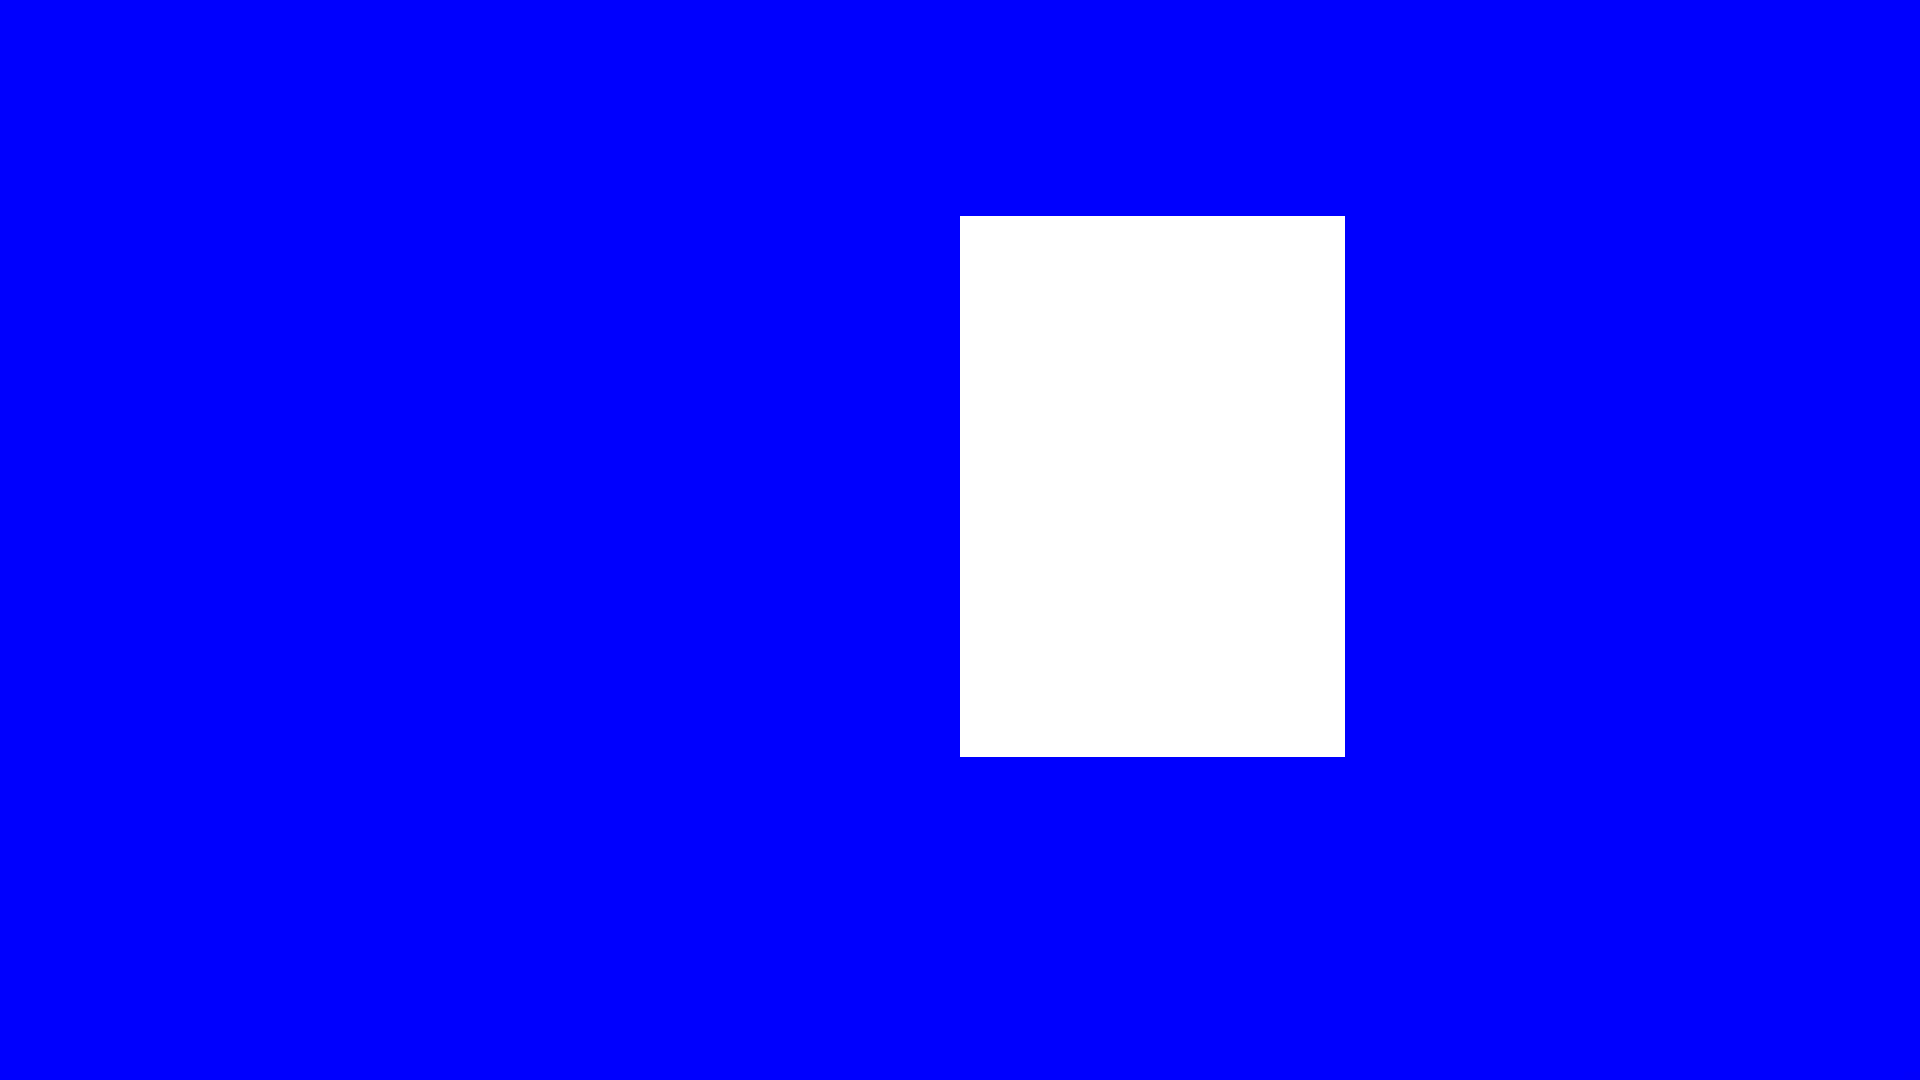

In [35]:
from PIL import Image, ImageDraw

def mask_bounding_boxes(image, bounding_boxes):
    """
    Masks the specified bounding boxes in the image with white color.
    The bounding box coordinates are given as ratios of the image size.

    :param image: A PIL Image object.
    :param bounding_boxes: A list of bounding boxes in the format (x_ratio, y_ratio, h_ratio, w_ratio).
    :return: A PIL Image object with the bounding boxes masked.
    """
    width, height = image.size
    draw = ImageDraw.Draw(image)

    for bbox in bounding_boxes:
        x_ratio, y_ratio, h_ratio, w_ratio = bbox
        x = x_ratio * width
        y = y_ratio * height
        w = w_ratio * width
        h = h_ratio * height
        draw.rectangle([x, y, x + w, y + h], fill="white")

    return image

image = Image.open('/nlp/scr/zyanzhe/Pix2Code/testset_100/rick.jpg')
display(mask_bounding_boxes(image, [[0.5, 0.2, 0.5, 0.2]]))

In [23]:
a = [-0.38095238095238093, -1.0, -0.9440559440559441, -0.6451612903225806, -0.48336252189141854, -0.6451612903225806, -1.0, -0.6666666666666666, -1.0, -0.972972972972973]
b = [-0.38095238095238093, -1.0, -0.9440559440559441, -0.6451612903225806, -0.48336252189141854, -0.6451612903225806, -1.0, -0.6666666666666666, -0.9521531100478469]
difference_of_means(a, b)

0.0